# IRD Xenium cell type annotation

This notebook documents the process of annotating cell types for the merged Xenium object in the IRD project. This approach uses a combination of sketching, or intelligent-subsampling, and unsupervised-clustering to find distinct cell types from their spatial expression profiles.

In [1]:
library(Seurat)
library(tidyverse)
library(qs2)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
qs2 0.1.5



## Section 1: Create Seurat object from counts matrix and metadata converted from Scanpy

In [27]:
counts <- ReadMtx(
  mtx = "/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/rds_workflow/mtx/matrix.mtx",
  features = "/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/rds_workflow/mtx/features.tsv",
  cells = "/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/rds_workflow/mtx/barcodes.tsv",
  feature.column = 1,
  cell.column = 1
)
obj <- CreateSeuratObject(
    counts = counts,
    meta.data = read.csv("/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/rds_workflow/mtx/metadata.tsv", sep="\t", header=T, row.names=1)
)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [28]:
obj <- RenameAssays(obj, RNA = "Xenium")

Renaming default assay from RNA to Xenium

Warning message:
“Key ‘rna_’ taken, using ‘xenium_’ instead”


In [30]:
obj

An object of class Seurat 
513 features across 5726156 samples within 1 assay 
Active assay: Xenium (513 features, 0 variable features)
 1 layer present: counts

### Remove snv probe genes and genes not shared between custom panels

These genes will skew the normalization and HVG selection, thus affecting clustering results

In [33]:
snv_genes <- rownames(obj)[grep("-WT|-ALT", rownames(obj))]
snv_genes

[1] "GNAS-p.R201H-WT"

In [38]:
# Load processed Xenium objects with v5 and v6 custom panels
v5_obj <- readRDS("/diskmnt/Projects/SenNet_analysis/Main.analysis/bm/Xenium/NBM/SN151R1-Ma1Fd2-2U1/SN151R1-Ma1Fd2-2U1_processed.rds")
v6_obj <- readRDS("/diskmnt/Projects/SenNet_analysis/Main.analysis/bm/Xenium/NBM/SN222R1-Ma1Fd2-1U1/SN222R1-Ma1Fd2-1U1_processed.rds")

shared_genes <- intersect(rownames(v5_obj), rownames(v6_obj))
print(length(shared_genes))

[1] 416


In [39]:
obj <- subset(obj, features = shared_genes)
obj


An object of class Seurat 
416 features across 5726156 samples within 1 assay 
Active assay: Xenium (416 features, 0 variable features)
 1 layer present: counts

In [ ]:
qs_save(obj, "/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_merge_seurat_sharedGenesOnly.qs")

## Section 2: Run the Seurat sketch data pipeline with Harmony integration

In [2]:
system2(command = "nohup",
        args = c("Rscript",
                 "/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/Xenium_processing/sketch_data.R",
                 "-i", "/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_merge_seurat_sharedGenesOnly.qs",
                 "-o", "/diskmnt/Users2/chouw/Projects/BM_spatial/IRD",
                 "-x", "IRD_JW_Xenium_merge",
                 "-n", "3000",
                 "--split_by", "Sample",
                 "--assay", "Xenium"),
        stdout = '/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/logs/nohup_IRDsketch.out',
        stderr = '/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/logs/nohup_IRDsketch.out')

## Section 3: Inspect sketch results and annotate cell types

In [ ]:
obj <- qs_read("/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_Xenium_sketched_harmonized.qs")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



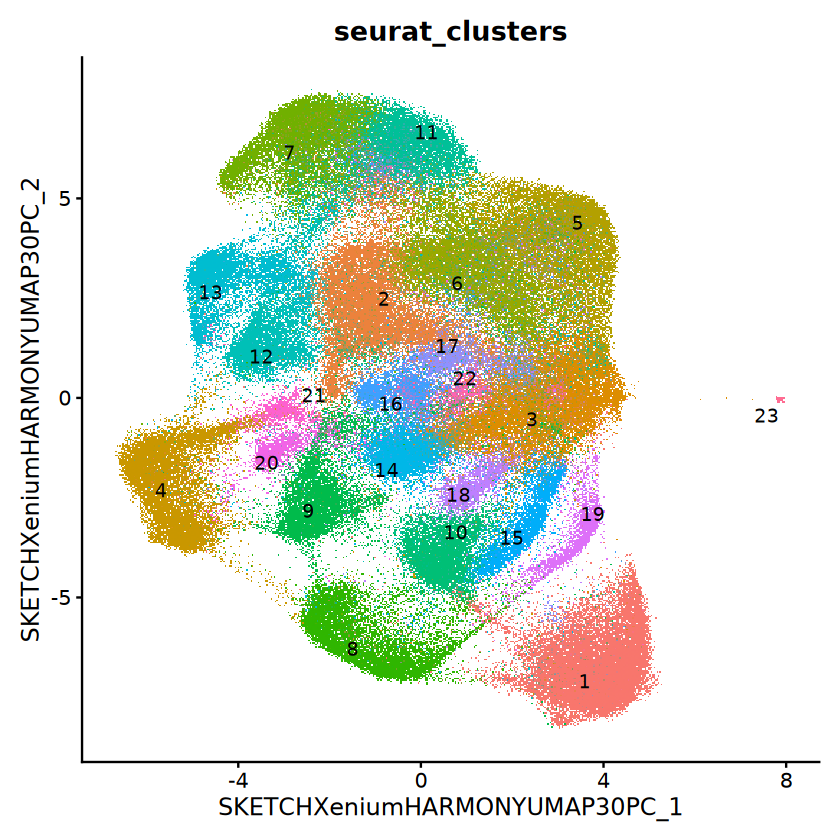

In [5]:
DefaultAssay(obj) <- "sketch"
DimPlot(obj, reduction = "sketched.Xenium.harmony_umap", group.by = "seurat_clusters", label = TRUE, repel = TRUE) + NoLegend()

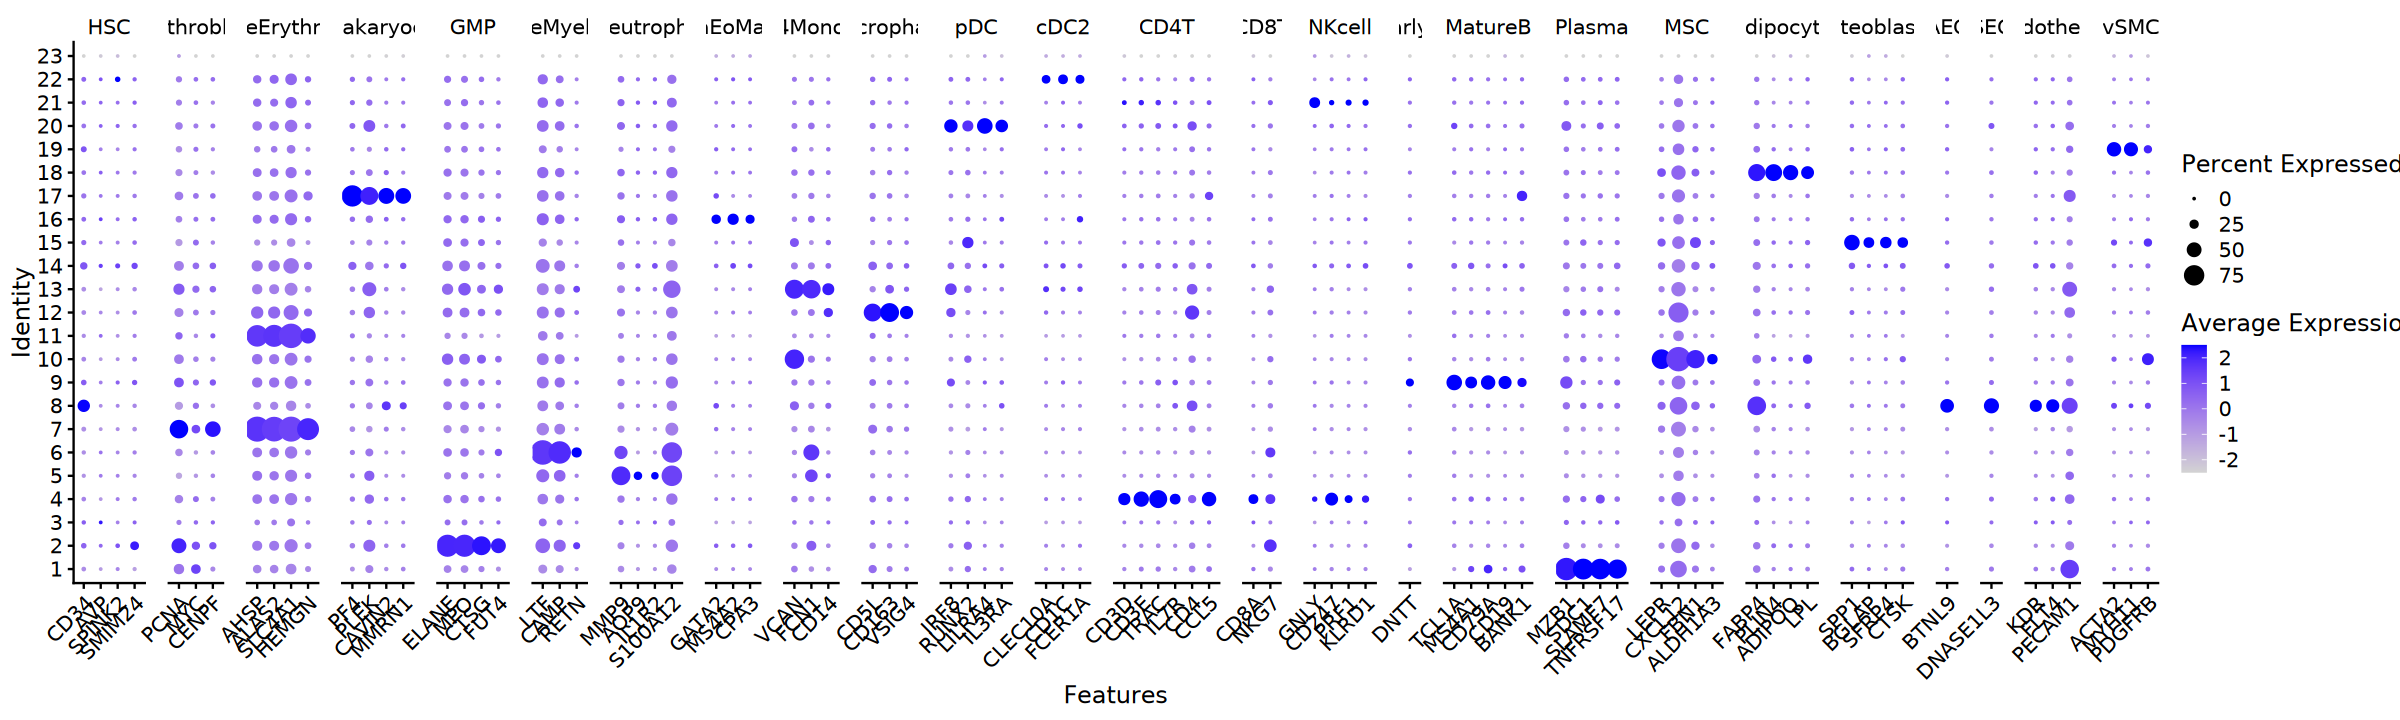

In [8]:
all_markers = list(
  HSC = c("CD34", "AVP", "SPINK2", "SMIM24"),
  Erythroblast = c("PCNA", "MYC", "CENPF"),  # "PARP1", "GATA1", 
  LateErythroid = c("AHSP", "ALAS2", "SLC4A1", "HEMGN"),
  Megakaryocyte = c("PF4", "PLEK", "CAVIN2", "MMRN1"),
  GMP = c("ELANE", "MPO", "CTSG", "FUT4"),
  LateMyeloid = c("LTF", "CAMP", "RETN"),
  Neutrophil = c("MMP9", "AQP9", "IL1R2", "S100A12"), ## "ITGAM", 
  BaEoMast = c("GATA2", "MS4A2", "CPA3"), ## "MS4A3", 
  CD14Monocyte = c("VCAN", "FCN1", "CD14"),
  Macrophage = c("CD5L", "CD163", "VSIG4"),
  pDC = c("IRF8", "RUNX2", "LILRA4", "IL3RA"),
  cDC2 = c("CLEC10A", "CD1C", "FCER1A"),
  CD4T = c("CD3D", "CD3E", "TRAC", "IL7R", "CD4", "CCL5"),
  CD8T = c("CD8A", "NKG7"),
  NKcell = c("GNLY", "CD247", "PRF1", "KLRD1"),
  EarlyB = c("DNTT"), ## "IGLL1", "VPREB1"
  MatureB = c("TCL1A", "MS4A1", "CD79A", "CD19", "BANK1"),
  Plasma = c("MZB1", "SDC1", "SLAMF7", "TNFRSF17"),
  MSC = c("LEPR", "CXCL12", "FBN1", "ALDH1A3"),
  Adipocyte = c("FABP4", "PLIN4", "ADIPOQ", "LPL"),
  Osteoblastic = c("SPP1", "BGLAP", "SFRP4", "CTSK"),
  AEC = c("BTNL9"),
  SEC = c("DNASE1L3"),
  Endothelial = c("KDR", "FLT4", "PECAM1"), #"ENG"
  vSMC = c("ACTA2", "MYH11", "PDGFRB")
)
options(repr.plot.width = 20, repr.plot.height = 6)
DotPlot(obj, features = all_markers, group.by = "seurat_clusters") + RotatedAxis()

### T subtyping

In [9]:
Graphs(obj)

[1] "sketch.Xenium_nn"  "sketch.Xenium_snn"

In [10]:
colnames(obj@meta.data)

[1] "orig.ident"                "nCount_RNA"               
 [3] "nFeature_RNA"              "x_centroid"               
 [5] "y_centroid"                "cell_area"                
 [7] "nucleus_area"              "Sample"                   
 [9] "UPN"                       "DI_UPN"                   
[11] "DI_Sample"                 "Collection"               
[13] "Panel"                     "MRD.Status"               
[15] "Months_PFS"                "nCounts"                  
[17] "annot"                     "Original_Barcode"         
[19] "nCount_Xenium"             "nFeature_Xenium"          
[21] "leverage.score"            "sketch.Xenium_snn_res.0.8"
[23] "seurat_clusters"           "T.subcluster"             
[25] "HSC.subcluster"            "B.subcluster"             
[27] "GMP.subcluster"            "sketch_subcluster"        
[29] "manual_anno_WC_sketch"     "celltype.full"            
[31] "celltype.full.score"       "sketch_project_anno"

Warning message in RunLeiden(object = object, method = method, partition.type = "RBConfigurationVertexPartition", :
“`random.seed` must be greater than 0 for leiden clustering, resetting `random.seed` to 1.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



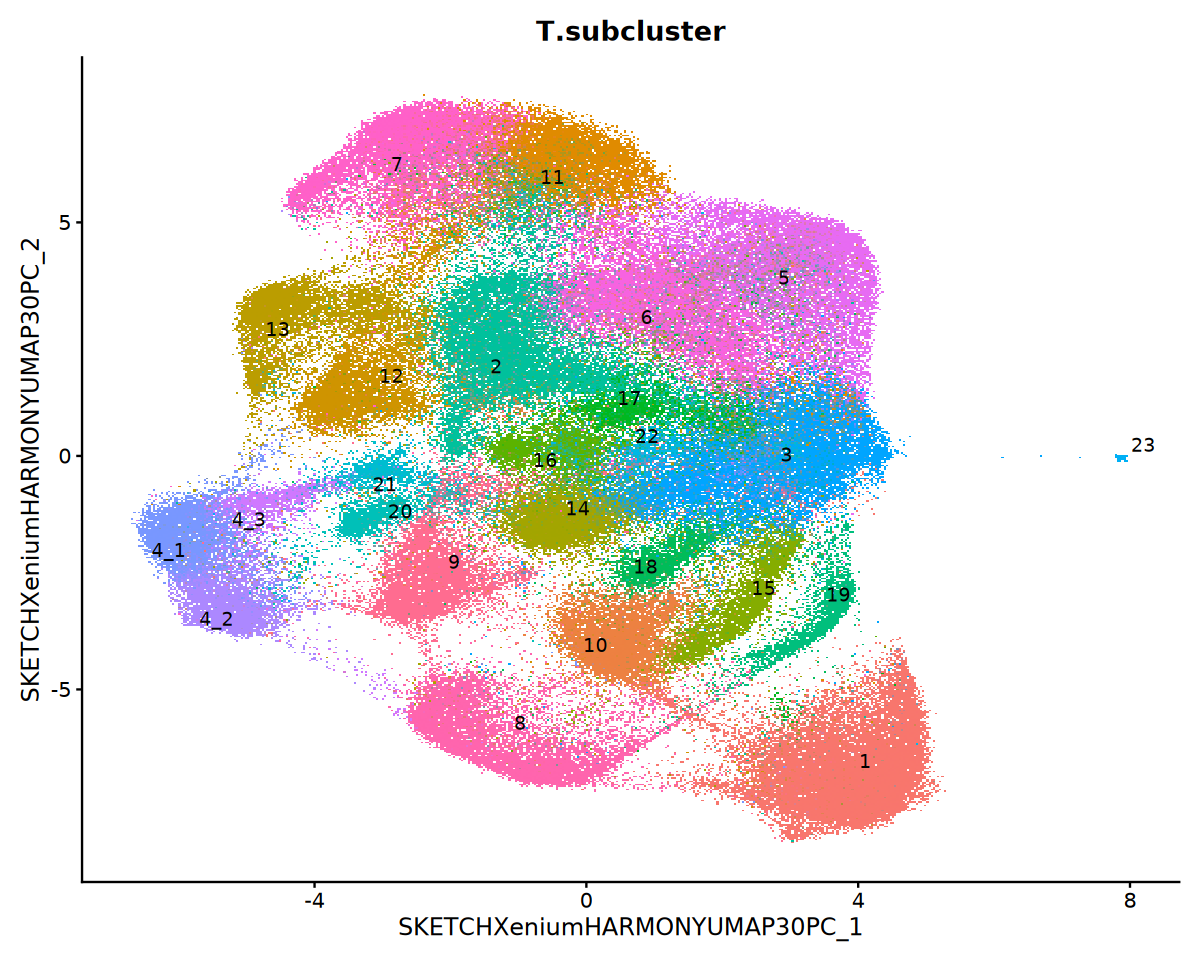

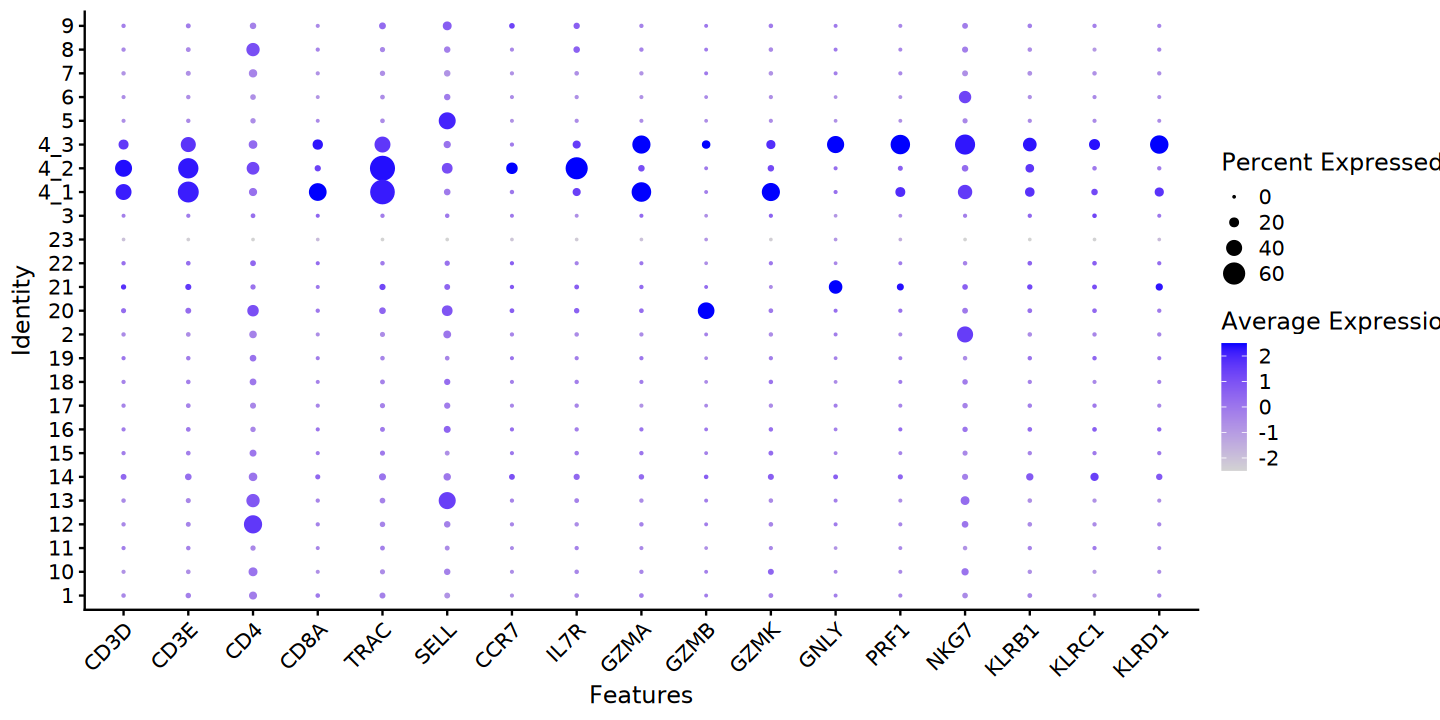

In [12]:
Idents(obj) <- "seurat_clusters"
obj <- FindSubCluster(obj, cluster = "4", graph.name = "sketch.Xenium_snn", subcluster.name = "T.subcluster", resolution = 0.2, algorithm = 4)
options(repr.plot.width = 10, repr.plot.height = 8)
DimPlot(obj, reduction = "sketched.Xenium.harmony_umap", group.by = "T.subcluster", label = TRUE, repel = TRUE) + NoLegend()
options(repr.plot.width = 12, repr.plot.height = 6)
DotPlot(obj, features = c("CD3D", "CD3E", "CD4", "CD8A", "TRAC", "SELL", "CCR7", "IL7R", "GZMA", "GZMB", "GZMK", "GNLY", "PRF1", "NKG7", "KLRB1", "KLRC1","KLRD1"), group.by = "T.subcluster") + RotatedAxis()

### B subtyping

Warning message in RunLeiden(object = object, method = method, partition.type = "RBConfigurationVertexPartition", :
“`random.seed` must be greater than 0 for leiden clustering, resetting `random.seed` to 1.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



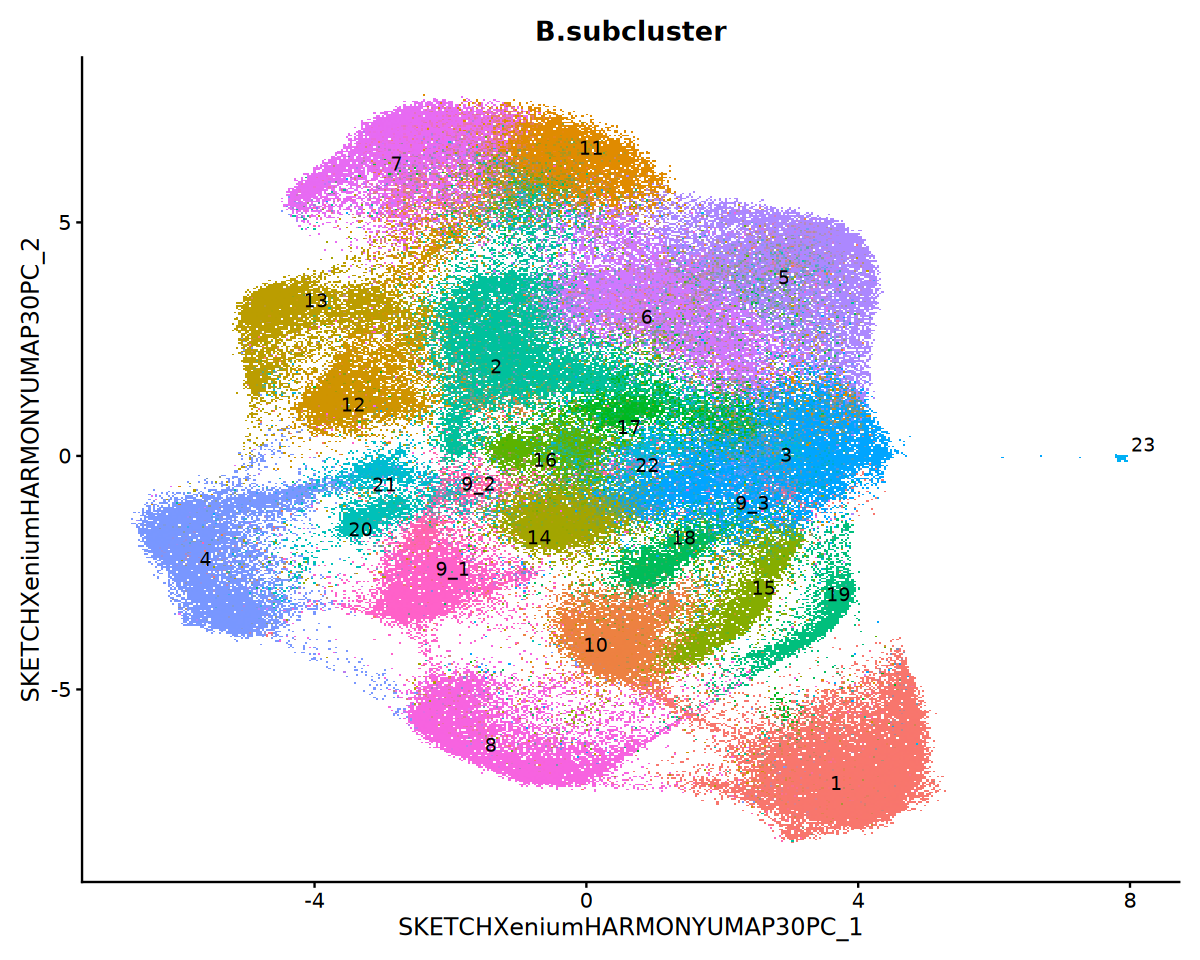

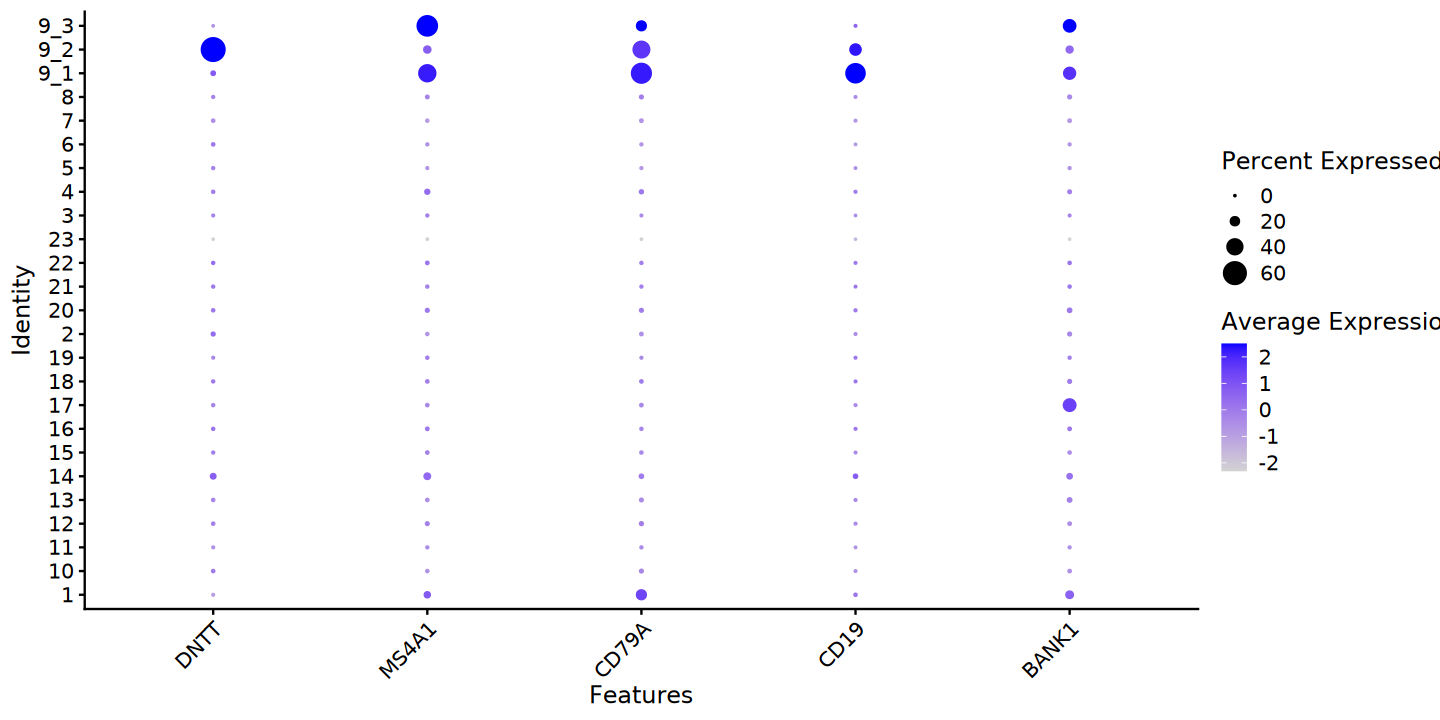

In [14]:
obj <- FindSubCluster(obj, cluster = "9", graph.name = "sketch.Xenium_snn", subcluster.name = "B.subcluster", resolution = 0.1, algorithm = 4)
options(repr.plot.width = 10, repr.plot.height = 8)
DimPlot(obj, reduction = "sketched.Xenium.harmony_umap", group.by = "B.subcluster", label = TRUE, repel = TRUE) + NoLegend()
options(repr.plot.width = 12, repr.plot.height = 6)
DotPlot(obj, features = c("DNTT", "MS4A1", "CD79A", "CD19", "BANK1"), group.by = "B.subcluster") + RotatedAxis()

### GMP subtyping

HSC markers are expressed in the GMP cluster - subcluster to separate them out

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



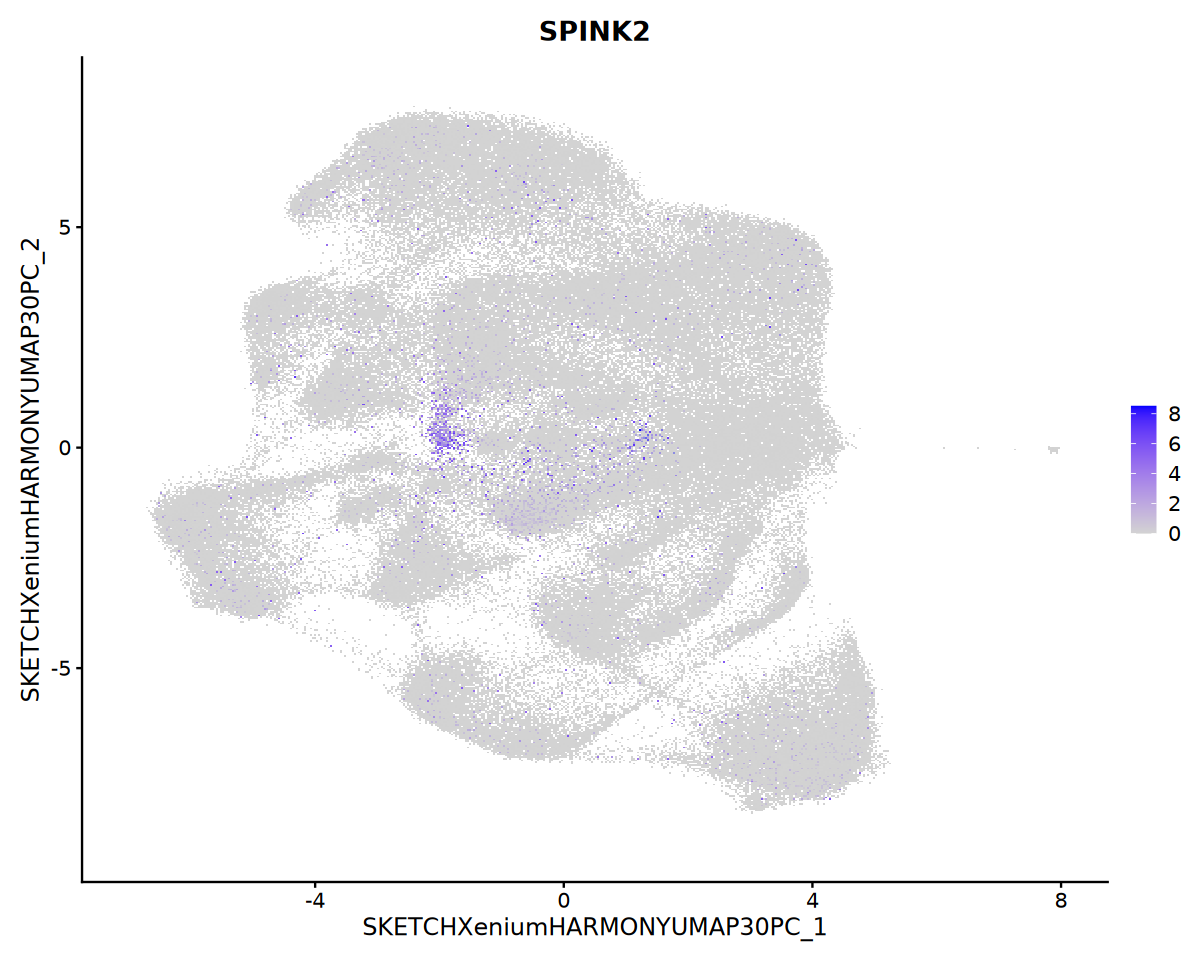

In [20]:
options(repr.plot.width = 10, repr.plot.height = 8)
FeaturePlot(obj, reduction = "sketched.Xenium.harmony_umap", features = "SPINK2")

Warning message in RunLeiden(object = object, method = method, partition.type = "RBConfigurationVertexPartition", :
“`random.seed` must be greater than 0 for leiden clustering, resetting `random.seed` to 1.”
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



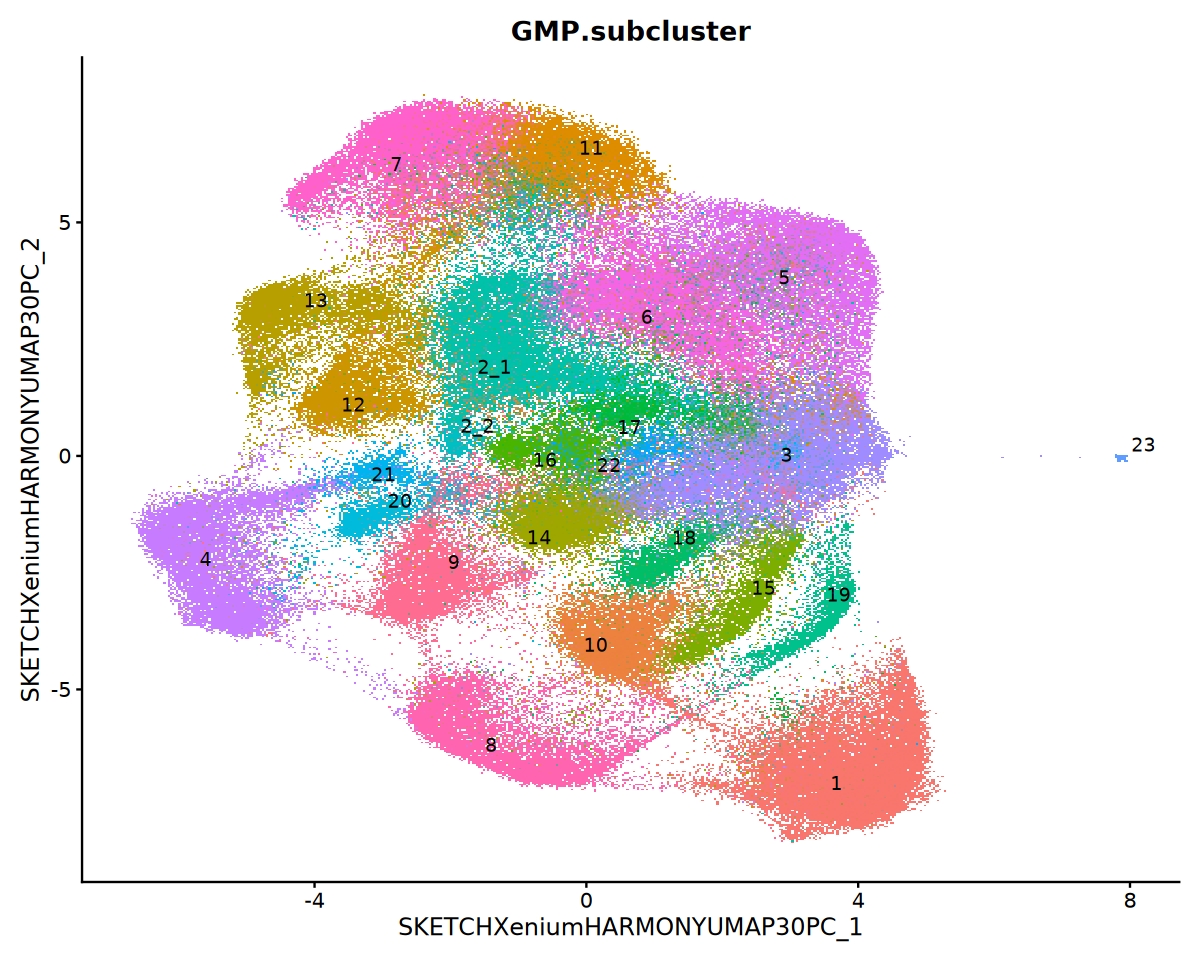

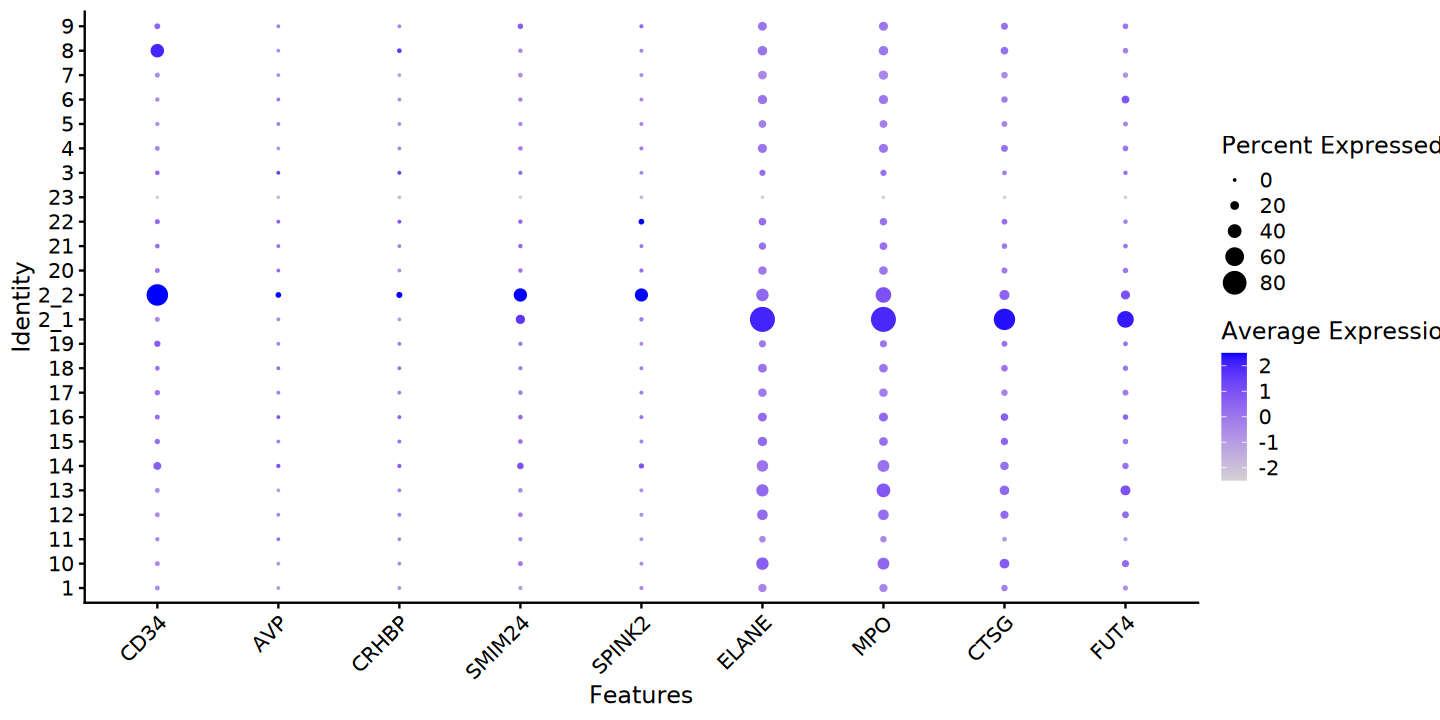

In [16]:
obj <- FindSubCluster(obj, cluster = "2", graph.name = "sketch.Xenium_snn", subcluster.name = "GMP.subcluster", resolution = 0.1, algorithm = 4)
options(repr.plot.width = 10, repr.plot.height = 8)
DimPlot(obj, reduction = "sketched.Xenium.harmony_umap", group.by = "GMP.subcluster", label = TRUE, repel = TRUE) + NoLegend()
options(repr.plot.width = 12, repr.plot.height = 6)
DotPlot(obj, features = c("CD34", "AVP", "CRHBP", "SMIM24", "SPINK2","ELANE", "MPO", "CTSG", "FUT4"), group.by = "GMP.subcluster") + RotatedAxis()

### Unify the subclutser annotation and annotate

In [21]:
colnames(obj@meta.data)

[1] "orig.ident"                "nCount_RNA"               
 [3] "nFeature_RNA"              "x_centroid"               
 [5] "y_centroid"                "cell_area"                
 [7] "nucleus_area"              "Sample"                   
 [9] "UPN"                       "DI_UPN"                   
[11] "DI_Sample"                 "Collection"               
[13] "Panel"                     "MRD.Status"               
[15] "Months_PFS"                "nCounts"                  
[17] "annot"                     "Original_Barcode"         
[19] "nCount_Xenium"             "nFeature_Xenium"          
[21] "leverage.score"            "sketch.Xenium_snn_res.0.8"
[23] "seurat_clusters"           "T.subcluster"             
[25] "HSC.subcluster"            "B.subcluster"             
[27] "GMP.subcluster"            "sketch_subcluster"        
[29] "manual_anno_WC_sketch"     "celltype.full"            
[31] "celltype.full.score"       "sketch_project_anno"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



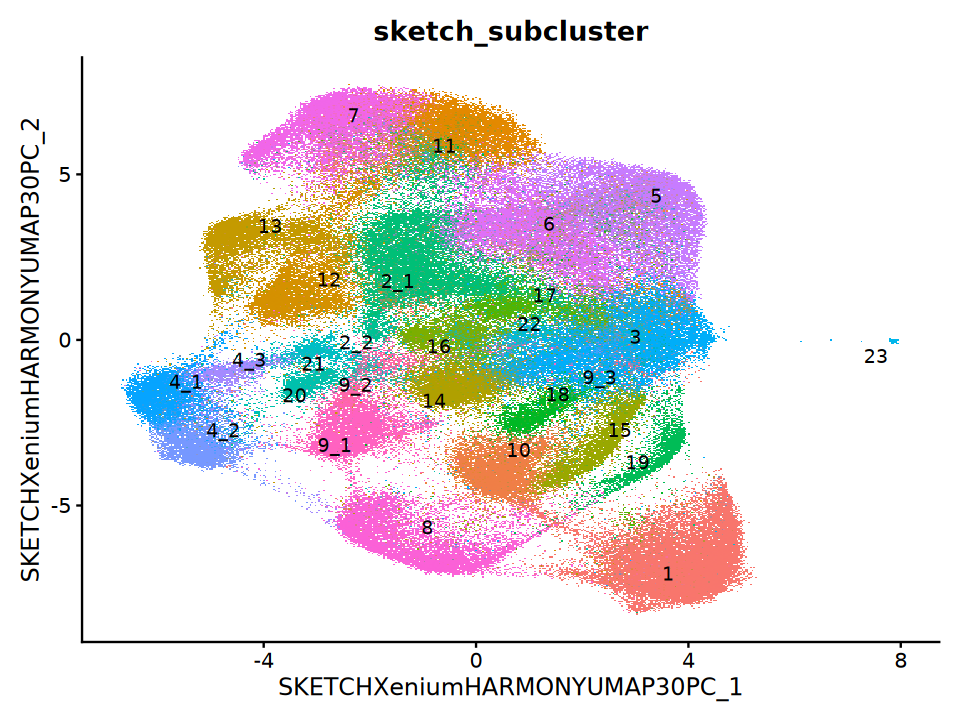

In [23]:
obj$sketch_subcluster <- ifelse(obj$seurat_clusters == "4", obj$T.subcluster, 
                                ifelse(obj$seurat_clusters == "9", obj$B.subcluster, 
                                       ifelse(obj$seurat_clusters == "2", obj$GMP.subcluster, 
                                              obj$seurat_clusters)))
options(repr.plot.width = 8, repr.plot.height = 6)
DimPlot(obj, reduction = "sketched.Xenium.harmony_umap", group.by = "sketch_subcluster", label = TRUE, repel = TRUE) + NoLegend()

In [ ]:
Idents(obj) <- "sketch_subcluster"
obj <- RenameIdents(obj, '1' = 'Plasma cell',
                         '2_1' = 'GMP',
                         '2_2' = 'HSPC',
                         '3' = 'Low confidence',
                         '4_1' = 'CD8 T',
                         '4_2' = 'CD4 T',
                         '4_3' = 'NK_T',
                         '5' = 'Neutrophil',
                         '6' = 'Late Myeloid',
                         '7' = 'Erythroid',
                         '8' = 'Endothelial',
                         '9_1' = 'Mature B',
                         '9_2' = 'Early B',
                         '9_3' = 'Mature B',
                         '10' = 'MSC',
                         '11' = 'Erythroid',
                         '12' = 'Macrophage',
                         '13' = 'Monocyte',
                         '14' = 'Low confidence',
                         '15' = 'Osteoblast',
                         '16' = 'Ba/Eo/Ma',
                         '17' = 'Megakaryocyte',
                         '18' = 'Adipocyte',
                         '19' = 'vSMC',
                         '20' = 'pDC',
                         '21' = 'NK',
                         '22' = 'cDC2',
                         '23' = 'Low confidence'
                         )
obj$manual_anno_WC_sketch <- Idents(obj)

In [ ]:
qs_save(obj, "/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_Xenium_sketched_harmonized.qs")

## Section 4: Project annotation back to full dataset

In [ ]:
system2(command = "nohup",
        args = c("Rscript",
                 "/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/Xenium_processing/project_sketch_data.R",
                 "-i", "/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_Xenium_sketched_harmonized.qs",
                 "-o", "/diskmnt/Users2/chouw/Projects/BM_spatial/IRD",
                 "-x", "IRD_JW_Xenium_merge",
                 "-a", "Xenium",
                 "-s", "sketch.Xenium",
                 "-r", "sketched.Xenium.harmony",
                 "-n", "manual_anno_WC_sketch",
                 "--group_by_col", "Sample"),
        stdout = '/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/logs/nohup_IRDsketchProject.out',
        stderr = '/diskmnt/Users2/chouw/Projects/SenNet_bone/src/spatial/logs/nohup_IRDsketchProject.out')

## Section 5: Inspect projection results

In [2]:
obj <- qs_read("/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_sketched_projected_umap.qs")

Some projected cell types with lower confidence were rescued by Julia. This is documented in a separate notebook: `/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/manual_plus_clustering_celltyping.ipynb`

In [3]:
revised_ct <- read.csv("/diskmnt/Projects/myeloma_scRNA_analysis/MMY_IRD/Xenium/analysis/merged_metadata.csv", row.names = 1)
head(revised_ct)

,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,DI_Sample,Collection,Panel,MRD.Status,Months_PFS,nCounts,annot,clust,ct,Original_Barcode
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
IRD_S18-30740A1U3_aaaefkpp-1,433.4302,1357.545,37.66031,23.93281,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,136,Erythro,Erythroid,Erythroid,aaaefkpp-1
IRD_S18-30740A1U3_aaaekejm-1,449.8539,1278.230,31.06750,20.81703,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,115,Granulo,Late Myeloid,Late Myeloid,aaaekejm-1
IRD_S18-30740A1U3_aaaekekb-1,438.3665,1361.509,46.24000,17.34000,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,137,Erythro,NK_T,NK,aaaekekb-1
IRD_S18-30740A1U3_aaaeonma-1,438.0077,1311.079,125.71500,59.38047,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,291,Erythro,Erythroid,Erythroid,aaaeonma-1
IRD_S18-30740A1U3_aaaflkno-1,373.2168,1557.585,46.19485,30.48047,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,88,Erythro,Erythroid,Erythroid,aaaflkno-1
IRD_S18-30740A1U3_aaagdehf-1,447.8926,1550.404,38.87953,27.99688,IRD_S18-30740A1U3,WU108,P136,P136_T0_S1,NDMM,W7JCJE_hMulti,Negative,26.8,97,Multiplet,Plasma Cell,PC,aaagdehf-1


In [ ]:
head(obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,⋯,seurat_clusters,T.subcluster,HSC.subcluster,B.subcluster,GMP.subcluster,sketch_subcluster,manual_anno_WC_sketch,celltype.full,celltype.full.score,sketch_project_anno
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>
IRD_S18-30740A1U3_aaaefkpp-1,IRD,136,52,433.4302,1357.545,37.66031,23.93281,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,NA,Erythroid,0.9998443,Erythroid
IRD_S18-30740A1U3_aaaekejm-1,IRD,115,39,449.8539,1278.230,31.06750,20.81703,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,NA,Late Myeloid,0.5501757,Late Myeloid
IRD_S18-30740A1U3_aaaekekb-1,IRD,137,66,438.3665,1361.509,46.24000,17.34000,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,NA,NK_T,0.8345521,NK_T
IRD_S18-30740A1U3_aaaeonma-1,IRD,291,85,438.0077,1311.079,125.71500,59.38047,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,NA,Erythroid,1.0000000,Erythroid
IRD_S18-30740A1U3_aaaflkno-1,IRD,88,22,373.2168,1557.585,46.19485,30.48047,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,NA,Erythroid,0.8278288,Erythroid
IRD_S18-30740A1U3_aaagdehf-1,IRD,97,41,447.8926,1550.404,38.87953,27.99688,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,NA,Plasma Cell,0.9727146,Plasma Cell


In [9]:
# Map the ct column from revised_ct onto obj@meta.data based on the same rownames
obj@meta.data$ct <- revised_ct[rownames(obj@meta.data), "ct"]
head(obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,x_centroid,y_centroid,cell_area,nucleus_area,Sample,UPN,DI_UPN,⋯,T.subcluster,HSC.subcluster,B.subcluster,GMP.subcluster,sketch_subcluster,manual_anno_WC_sketch,celltype.full,celltype.full.score,sketch_project_anno,ct
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<chr>,<chr>
IRD_S18-30740A1U3_aaaefkpp-1,IRD,136,52,433.4302,1357.545,37.66031,23.93281,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,Erythroid,0.9998443,Erythroid,Erythroid
IRD_S18-30740A1U3_aaaekejm-1,IRD,115,39,449.8539,1278.230,31.06750,20.81703,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,Late Myeloid,0.5501757,Late Myeloid,Late Myeloid
IRD_S18-30740A1U3_aaaekekb-1,IRD,137,66,438.3665,1361.509,46.24000,17.34000,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,NK_T,0.8345521,NK_T,NK
IRD_S18-30740A1U3_aaaeonma-1,IRD,291,85,438.0077,1311.079,125.71500,59.38047,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,Erythroid,1.0000000,Erythroid,Erythroid
IRD_S18-30740A1U3_aaaflkno-1,IRD,88,22,373.2168,1557.585,46.19485,30.48047,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,Erythroid,0.8278288,Erythroid,Erythroid
IRD_S18-30740A1U3_aaagdehf-1,IRD,97,41,447.8926,1550.404,38.87953,27.99688,IRD_S18-30740A1U3,WU108,P136,⋯,NA,NA,NA,NA,NA,NA,Plasma Cell,0.9727146,Plasma Cell,PC


In [ ]:
qs_save(obj, "/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_sketched_projected_umap.qs")

In [10]:
DefaultAssay(obj) <- "sketch"

In [12]:
obj

An object of class Seurat 
832 features across 5726156 samples within 2 assays 
Active assay: sketch.Xenium (416 features, 416 variable features)
 137 layers present: data.IRD_S18-30740A1U3, data.S11-3564A1U1, data.S13-35096A1U1, data.S13-47674A1U1, data.S14-11561A1U1, data.S14-14053A1U1, data.S14-14053A1U2, data.S14-18864-A1U1, data.S14-22950-A1U1, data.S14-9876A1U1, data.S15-15758-A1U1, data.S16-26183A1U1, data.S16-30080A1U1, data.S17-24784A1U1, data.S17-24784A1U2, data.S17-32736-A1U1, data.S17-34578-A1U1, data.S17-5570A1U1, data.S18-36373A1U1, data.S18-461-A1U1, data.S18-6148A1U1, data.S19-25371-A1U1, data.S20-2375-A1U1, data.S21-1209-A1U1, data.S21-19998-A1U1Q1, data.S21-19998-A1U1Q2, data.S22-3386-A1U1, data.S24-19138A1U1, data.SN113R1-Ma1Fd2-2U2, data.SN126F1-Ma1Fd2-4U3, data.SN131R1-Ma1Fd2-12U1, data.SN151R1-Ma1Fd2-2U1, data.SN154R1-Ma1Fd2-1U1, data.SN160R1-Ma1Fd2-15U1, data.SN161R1-Ma1Fd2-3U1, data.SN169R1-Ma1Fd2-1U1, data.SN174R1-14U1, data.SN198R1-Ma1Fd2-1U2, data.SN200R1-Ma1

In [22]:
ct_palette <- c(
  "HSPC" = "#d6e376",
  "Erythroid" = "#cfcfcf",
  "Megakaryocyte" = "#8f8f8f",
  "GMP" = "#88cf46",
  "Late Myeloid" = "#4ab300",
  "Neutrophil" = "#95ad74",
  "Ba/Eo/Ma" = "#618038",
  "cDC" = "#3bff8c",
  "Monocyte" = "#3dd49f",
  "Macrophage" = "#03ab70",
  "pDC" = "#a5c3c4",
  "CD4 T" = "#ff8400",
  "CD8 T" = "#ff0000",
  "NK" = "#9302d1",
  "Early B" = "#7cb2e6",
  "Mature B" = "#045eb5",
  "PC" = "#ffbafd",
  "MSC" = "#cfc10a",
  "Fibro/Osteo" = "#ba9e00",
  "Adipocyte" = "#ffe600",
  "Endothelial" = "#cc7e7e",
  "vSMC/Pericyte" = "#ad4b8e",
  "Low Confidence" = "#FFFFFF"
)

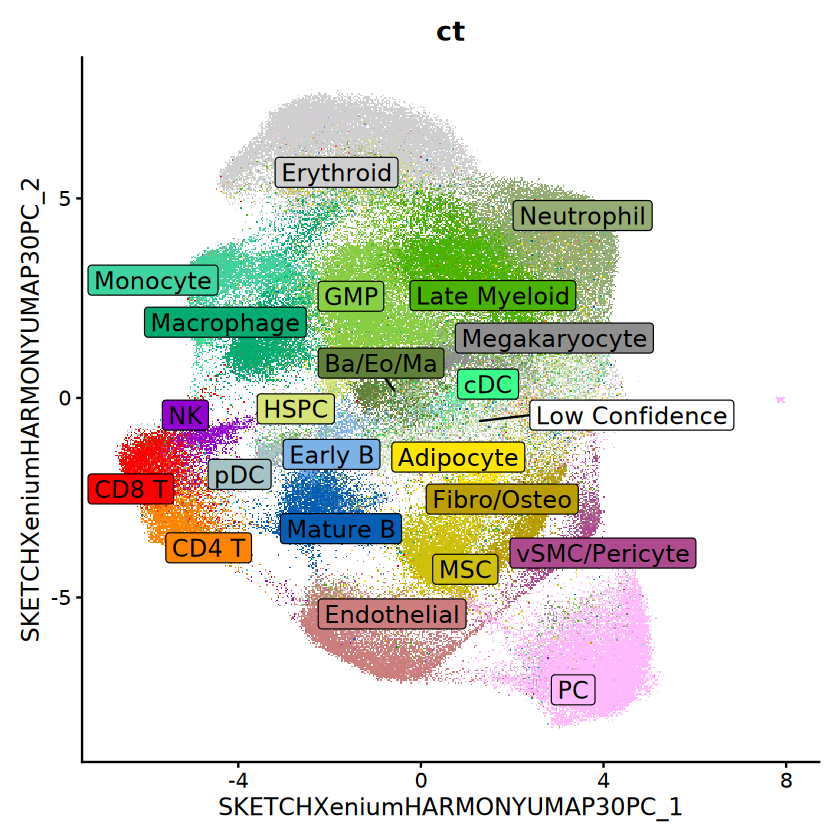

In [26]:
DimPlot(obj, 
        reduction = "sketched.Xenium.harmony_umap", 
        group.by = "ct", 
        cols = ct_palette,
        label = TRUE, 
        repel = TRUE, 
        label.size = 5, 
        label.box = TRUE, 
        raster = TRUE) + NoLegend()
ggsave("/diskmnt/Users2/chouw/Projects/BM_spatial/IRD/IRD_JW_Xenium_merge_sketched_projected_umap_annotated.pdf", width = 10, height = 8, dpi = 300)